<a href="https://colab.research.google.com/github/justinfmccarty/CityEnergyAnalyst_bigmacc/blob/master/Calculate_Heat%2BCool_Periods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining Heating and Cooling Seasons

This notebook uses effective tempreature (Houghton and Yaglou, 1923) to calculate a sliding effective temperture for each day of the year and then detemrine where to bracket out heating and cooling seasons following Wang et al (2015).

*Houghten, F., Yaglou, C., 1923. Determining lines of equal comfort. ASHVE Trans. 29, 163–176.*

*Wang Y, Wang L, Liu Y, Ding P, Deng S, Long E. Defining air-conditioning and heating seasons based on human thermal perception and building energy efficiency. Urban Clim 2015;14:544–53. doi:10.1016/j.uclim.2015.09.008.*

In [1]:
!pip install ladybug-core

     |████████████████████████████████| 225kB 5.6MB/s 
     |████████████████████████████████| 122kB 5.9MB/s 


In [3]:
import random
import numpy as np
import pandas as pd
import urllib
import zipfile
from ladybug.epw import EPW

In [37]:
def calcET(dbt,rh):
  effective_temp = dbt - 0.4*(1-rh)
  return effective_temp

def calcSET(effectivetemps):
  SETs = []
  for i in list(range(0,len(effectivetemps)-4)):
    SETdaily = (sum((effectivetemps[i],effectivetemps[i+1],effectivetemps[i+2],effectivetemps[i+3],effectivetemps[i+4])))/5
    SETs.append(SETdaily)
  return SETs

def createSET(dbt,rh):
  idx = pd.date_range(freq="h", start="2018-01-01", periods=365*24)
  data = pd.DataFrame(data={'dbt': dbt,
                            'rh': rh},
                      index=idx)
  data['eff_temp'] = data.apply(lambda x: calcET(x['dbt'],x['rh']), axis=1 )
  data_daily = data.resample('D').mean()

  efftemps = data_daily['eff_temp'].values.tolist()
  efftemps[365:369] = efftemps[0:4]

  data_daily['SET'] = calcSET(efftemps)
  return data_daily

In [5]:
url = 'http://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/CAN_Canada/BC_British_Columbia/CAN_BC_Vancouver.Intl.AP.718920_CWEC.zip'
urllib.request.urlretrieve(url,'/content/yvr.zip')

zf = zipfile.ZipFile('/content/yvr.zip', 'r')
zf.extractall('/content/yvr')
zf.close()

In [40]:
# best to change out the use of ladybug epw module due to pandas 

epw_path = '/content/yvr/CAN_BC_Vancouver.Intl.AP.718920_CWEC.epw'
epw = EPW(epw_path)
epw._import_data()
# df = lbp.DataFrame.from_epw(epw)
# df.head()
dbt_list = epw.dry_bulb_temperature.values
rh_list_percent = epw.relative_humidity.values

rh_list = []

for i in rh_list_percent:
  rh_list.append(i/100)

daily_data = np.round(createSET(dbt_list,rh_list),2)


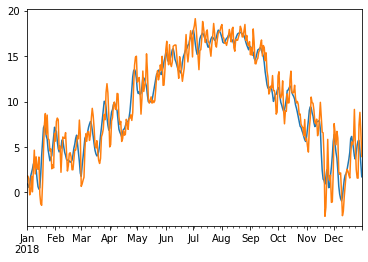

In [45]:
daily_data['SET'].plot.line()
daily_data['dbt'].plot.line()